# Predicting Risk of Heart Disease Based on Medical History

### INTRODUCTION

"Heart disease" is a catch-all term used to describe a variety of conditions affecting the heart or blood vessels. As the heart is responsible for the proper circulation of blood throughout the body, diseases of the heart can have lifelong and potentially fatal consequences, such as heart attacks, heart failure, or strokes. Many factors play a role in an individual’s heart health, from chosen behaviours such as diet, level of exercise or smoking, to genetic variables such as blood pressure and heart rate. Knowing the influence that medical history has on the risk of heart disease, we aim to create a model that can predict whether a patient has heart disease based on their unique medical history. Perhaps we may look specifically at how cholesterol levels, fasting blood sugar, chest pain, blood pressure, and heart rate could act as potential predictors.

The question we aim to answer through the creation of the model is, “Can we predict whether or not a patient will be at risk of heart disease based on existing medical history?”.

The dataset we will be using to answer this question is the Cleveland Heart Disease database. This database was donated and completed on June 30th, 1988 by the V.A. Medical Center, Long Beach and Cleveland Clinic Foundation. It consists of a total of 76 variables relating to heart disease patients, but for our purposes, we will be summarizing it into our 2 chosen predictor variables.

### METHODS

We will conduct our data analysis using K-nearest neighbors and using the columns of age, trestbps (resting blood pressure), and condition (whether they have heart disease or not). One way we will visualize the results will be using a scatter plot with lines (showcasing general trends) in terms of comparison with these variables in the raw dataset to conclude how these factors affect the likelihood of having heart disease. Than we will make two bar plot for the correct and incorrect diagonosis of heart disease, to get a more visualization of how well our model performed.

# CODE STARTS HERE

In [ ]:
#run these cells to start

library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### First, we loaded the file into the notebook from the internet. The condition column was changed into a factor, so further visualization don't recognize condition as a continuous variable.

In [ ]:
data <- read_csv("https://raw.githubusercontent.com/LordofSabres/Team_Pineapples_DSCI_100/main/heart_cleveland_upload.csv") |>
mutate(condition = as.factor(condition))
data

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
35,0,3,138,183,0,0,182,0,1.4,0,0,0,0
35,1,3,126,282,0,2,156,1,0.0,0,0,2,1


Table 1: Initial Dataset Loaded from the Web.

#### Then, we filtered the data by the desired variables (specifically, Age, resting blood pressure, and their condition of whether they have heart disease or not), sliced and split the filtered dataset. After the initial split, we further split the data into a testing and training set. We would use the training data to train our model and test this with our testing set. 

In [28]:
data_filter <- data |>
    select(age, trestbps, condition)

#data_filter

data_slice <- data_filter

data_split <- data_slice |>
    initial_split(prop = 0.5, strata = condition)

data_train <- training(data_split)

data_testing <- testing(data_split)
data_train

data_testing

age,trestbps,condition
<dbl>,<dbl>,<fct>
66,150,0
64,170,0
60,150,0
⋮,⋮,⋮
41,110,1
40,110,1
40,152,1


age,trestbps,condition
<dbl>,<dbl>,<fct>
69,160,0
69,140,0
64,110,0
⋮,⋮,⋮
35,120,1
35,138,0
35,126,1


Table 2: Filtered Training and Testing Data

#### We then created a recipe using the desired predictors from the training set, performing the necessary preprossesing. We created a model specification with tuning on the number of neighbors. We then performed a 10-fold cross-validation on the training set and created a tibble with k values from 1 to 10. We threaded the recipe and modeled through a workflow, using tune_grid to add in our vfold and grid from the previous step. Lastly, we collected the metrics from the workflow analysis and plotted the k versus the accuracy.

In [ ]:
set.seed(6000)
heart_recipe<-recipe(condition~age, trestbps, data=data_train)|>
step_center(all_numeric_predictors())|>
step_scale(all_numeric_predictors())

heart_tune<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")
heart_vfold<-vfold_cv(data_train, v=10, strata=condition)
grid_heart<-tibble(neighbors=seq(from=1, to=10, by=1))

heart_results<-workflow()|>
add_recipe(heart_recipe)|>
add_model(heart_tune)|>
tune_grid(resamples=heart_vfold, grid=grid_heart)|>
collect_metrics()
                  
accuracies<- heart_results|>
                   filter(.metric=="accuracy")      


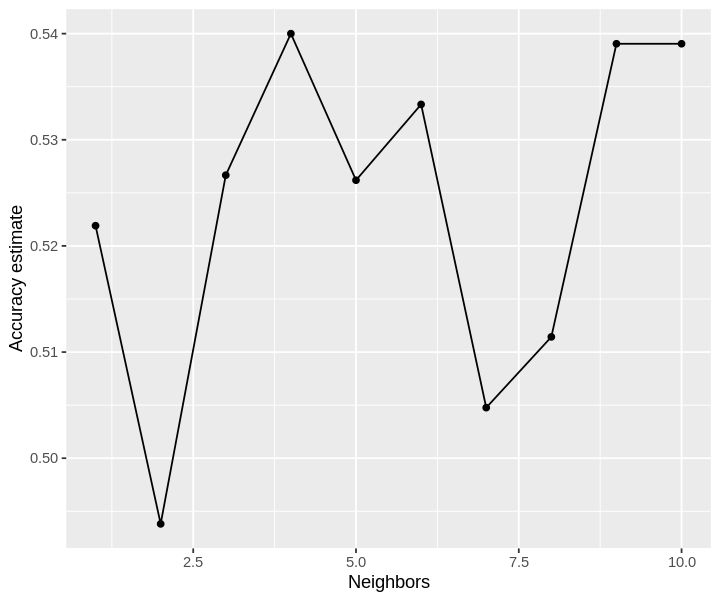

In [ ]:
heart_accuracy_plot<-ggplot(accuracies,aes(x=neighbors, y=mean))+
geom_point()+
geom_line()+
labs(x="Neighbors", y="Accuracy estimate")
options(repr.plot.height = 5, repr.plot.width = 6)
heart_accuracy_plot

Figure 1: Graph of K-Nearest Neighbours Accuracy Using Cross Validation

#### Finally, we built a new model specification with the best value for K found in the above plot, passed the model specification and the training data set through the fit() function, and used this model to predict on the test dataset and report the accuracy of the prediction. 

In [ ]:
set.seed(3036)
heart_spec<-nearest_neighbor(weight_func="rectangular", neighbors=6)|>
set_engine("kknn")|>
set_mode("classification")

heart_fit<-workflow()|>
add_recipe(heart_recipe)|>
add_model(heart_spec)|>
fit(data=data_train)

heart_prediction<-predict(heart_fit, data_testing)|>
bind_cols(data_testing)

heart_metrics<-heart_prediction|>
metrics(truth=condition, estimate=.pred_class)
heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48993289
kap,binary,-0.05950599


Table 3: Metrics on Testing Data

#### Following our report of the accuracy of the prediction, we wanted to view both the testing sets and training sets to observe if there were any trends that were noticeable in order to report our findings, so using a line graph (geom_line()), we compared the Resting Blood Pressure and Age of subjects with the presence of heart disease as a condition to note the differences in trends for those that did have heart disease and those that did not.

In [52]:
options(repr.plot.width = 30, repr.plot.height = 15) 

training_line <- ggplot(data_train, aes(x = trestbps, y = age)) +
    geom_line(aes(color = condition, shape = condition)) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Age (Years)", color = "Presence of Heart Disease (0 = no, 1 = yes)", shape = "Presence of Heart Disease (0 = no, 1 = yes)") +
    ggtitle("Graph of Age vs Resting Blood Pressure (mmHg) for Training Data")+
    theme(text = element_text(size = 15))

Warning message:
“Ignoring unknown aesthetics: shape”


In [55]:
options(repr.plot.width = 30, repr.plot.height = 15) 

testing_line <- ggplot(data_testing, aes(x = trestbps, y = age)) +
    geom_line(aes(color = condition, shape = condition)) +
    labs(x = "Resting Blood Pressure (mmHg)", y = "Age (Years)", color = "Presence of Heart Disease (0 = no, 1 = yes)", shape = "Presence of Heart Disease (0 = no, 1 = yes)") +
    ggtitle("Graph of Age vs Resting Blood Pressure (mmHg) for Testing Data") +
theme(text = element_text(size = 15))

Warning message:
“Ignoring unknown aesthetics: shape”


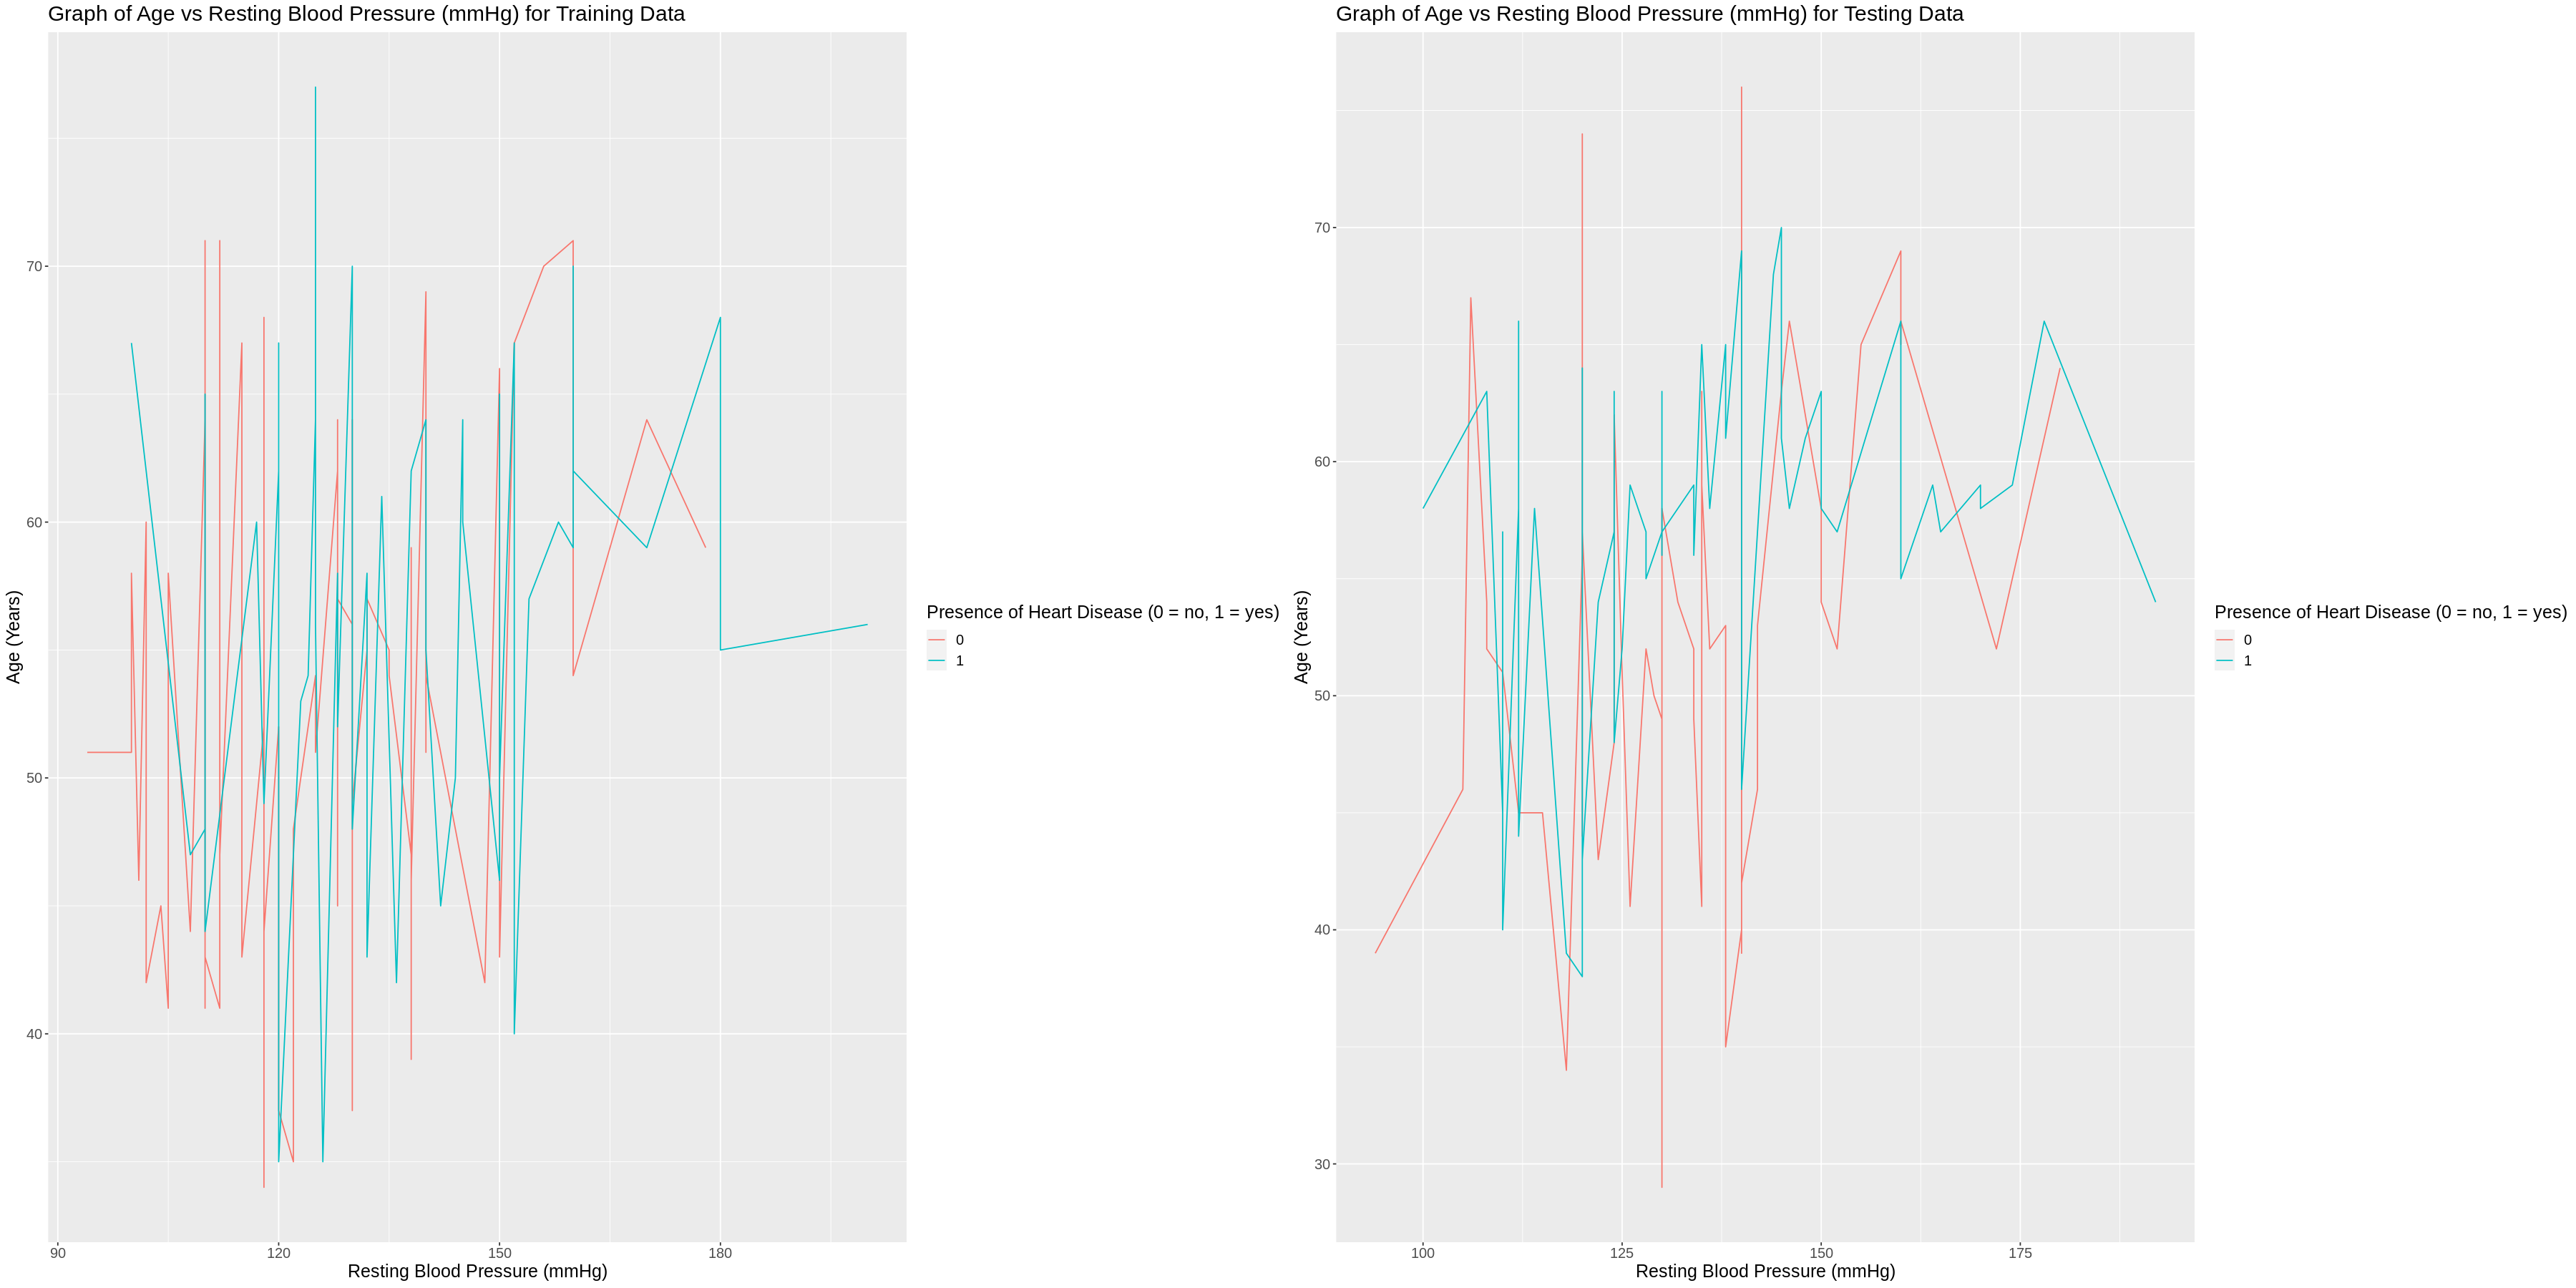

In [56]:
cowplot::plot_grid(training_line, testing_line)

Figure 2: Graph of Age(Years) vs Resting Blood Pressure (mmHg) for Predicting Heart Disease for Training Data Side by Side

#### Finally, we visualized the accuracy of our prediction model through comparing how many predictions of the conditions of heart disease were correctly identified and how many were not and graphed them using bar graphs to visualize them best. First, we sliced our data from the prediction classes and conditions to the main points and observed. Then we graphed the results using geom_bar.

In [31]:
testing_correct <- heart_prediction |>
select(.pred_class, condition) |>
dplyr::count(.pred_class, condition)
testing_predicted_correct <- testing_correct |>
slice(1,4) |>
select(condition, n)
testing_predicted_correct

condition,n
<fct>,<int>
0,58
1,15


Table 4: Correctly Predicted Conditions for Heart Disease. (0 = No Disease, 1 = Yes Disease)

In [32]:
testing_predicted_incorrect <- testing_correct |>
slice(2,3) |>
select(condition, n)
testing_predicted_incorrect

condition,n
<fct>,<int>
1,54
0,22


Table 5: Incorrectly Predicted Conditions for Heart Disease. (0 = No Disease, 1 = Yes Disease)

In [30]:
options(repr.plot.width = 20, repr.plot.height = 10) 
count_graph_correct_pred <- testing_predicted_correct |>
ggplot(aes(x = condition, y = n)) +
geom_bar(stat = "identity", position = "dodge", fill = "light green") +
xlab( " 1 = Heart Disease, 0 = No Heart Disease") +
ylab("Total Count") +
ggtitle("Graph of Correctly Predicted Heart Disease") +
theme(text = element_text(size = 15))

In [33]:
options(repr.plot.width = 20, repr.plot.height = 10) 
count_graph_incorrect <- testing_predicted_incorrect |>
ggplot(aes(x = condition, y = n)) +
geom_bar(stat = "identity", position = "dodge", fill = "red") +
xlab( " 1 = Heart Disease, 0 = No Heart Disease") +
ylab("Total Count") +
ggtitle("Graph of Incorrectly Predicted Heart Disease") +
theme(text = element_text(size = 15))

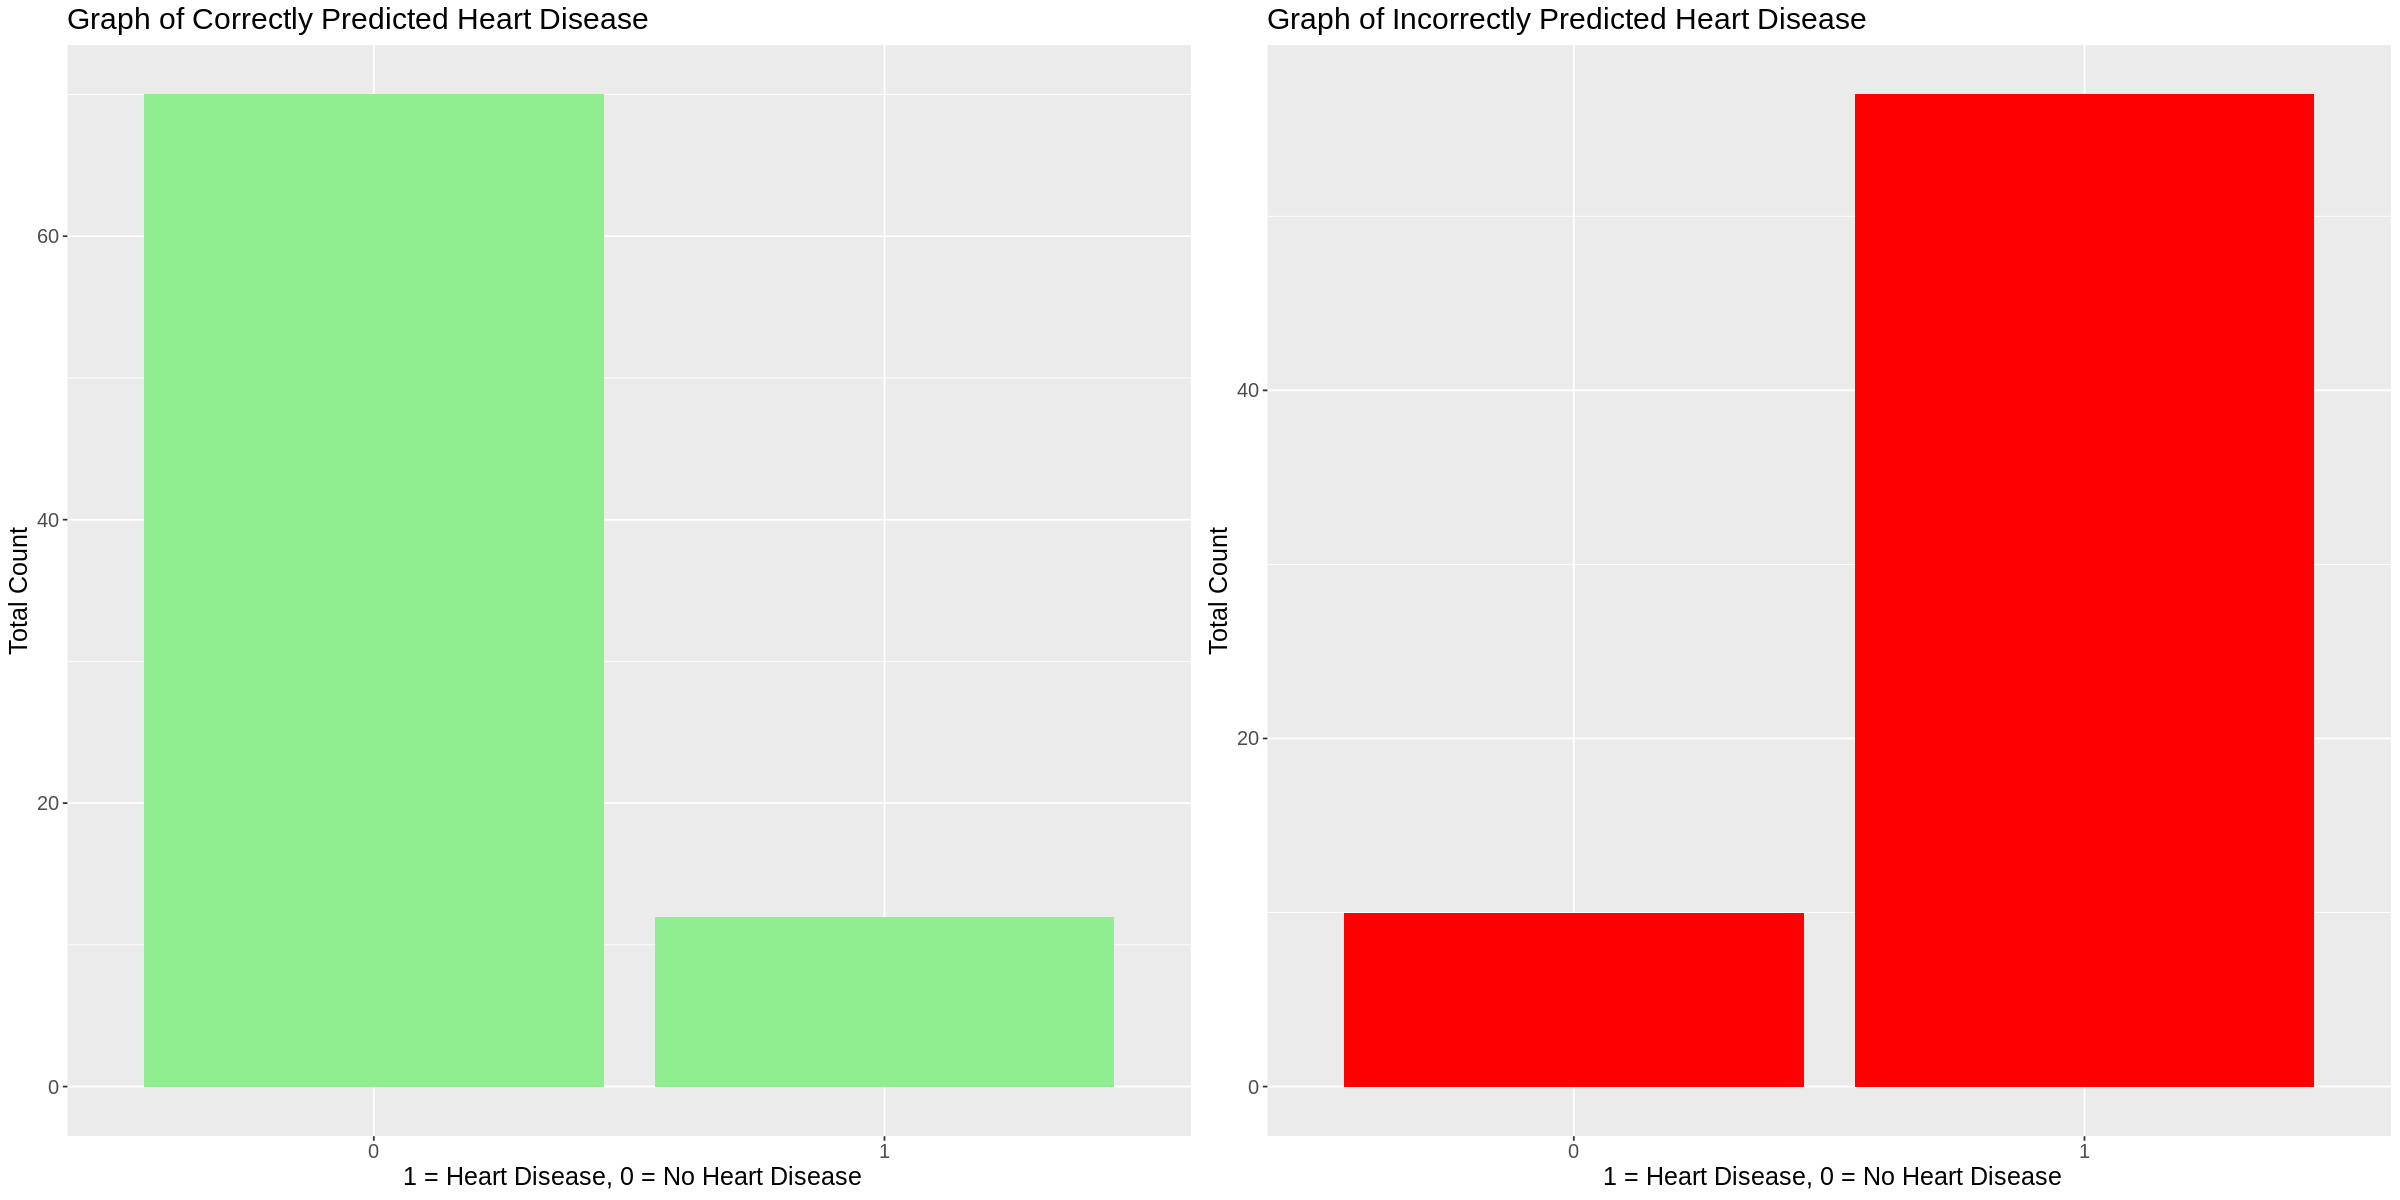

In [34]:
cowplot::plot_grid(count_graph_correct_pred, count_graph_incorrect)

Figure 3: Correct and Incorrect Diagnosis of Heart Disease Side by Side

### DISCUSSION

We found that resting blood pressure and age are not positively correlated with the likelihood of having heart disease. The distribution of the presence of heart disease did not support the trends hypothesized; that increasing resting blood pressure and age are associated with increasing occurrence of heart disease. In other words, there was no significant increase in prevalence of heart disease with increasing age or blood pressure. This could be due to the fact that there are multiple influencing factors for heart disease that were not taken into account: our model was limited to the variables accessible in our dataset. For example, genetic factors, diet, race, socioeconomic status, and second hand exposure to smoke are all elements that could significantly impact the frequency and distribution of heart disease. 

Such findings, or apparent lack thereof, could lead researchers to explore new areas beyond the field of medicine in search for more sociologically based factors relating to the risk of heart disease. Coupling our findings with the factors discussed above could lead to future questions regarding the possibility of the connection between heart disease and race. Examples of relevant questions could be: “Are certain races more prone to heart disease than others? How does socioeconomic status play a role in these findings?” . Additionally, researchers might take genetic factors into account, perhaps by examining the different biomarkers associated with different populations that may predispose an individual to heart disease. 


### CITATIONS / REFERENCES

Janosi, Andras, Steinbrunn, William, Pfisterer, Matthias, and Detrano, Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Bays, H., Taub, P., Epstein, E., Michos, E., Ferraro, R., Bailey, A., Kelli, H., Ferdinand, K., Echols, M., Weintraub, H., Bostrom, J., Johnson, H., Hoppe, K., Shapiro, M., German, C., Virani, S., Hussain, A., Ballantyne, C., Agha, A., & Toth, P. (2021). Ten things to know about ten cardiovascular disease risk factors. American journal of preventive cardiology, 5, 100149. https://doi.org/10.1016/j.ajpc.2021.100149

CDC. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity 